# First pass at analyzing O2 dilution data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pboc.plotting
import sys
sys.path.insert(0, '../../../')
import mwc_growth as mwc
import pandas as pd
import pboc.mcmc
import theano.tensor as tt
import pymc3 as pm
import matlab.engine as matlab
import scipy.optimize
import glob
import seaborn as sns
eng = matlab.start_matlab()
colors = pboc.plotting.set_plotting_style()
%matplotlib inline

## Calculating the calibration factor.

In [2]:
def cell_to_dict(file, eng, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest.

    The returned properties are
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.


    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    eng: MATLAB engine object
        Engine of running matlab session.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be
        exactly how they are defined in the cell file.

    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files.
    """

    # Ensure the supplied file is actually a .mat and other types are correct.
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError(
            "add_props is {0} and not dict.".format(type(add_props)))
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError(
            "add_props must be list. Type is currently {0}.".format(type(excluded_props)))

    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID',
            'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo', 'birth_area', 'death_area']

    # Load the mat file using MATLAB.
    eng.workspace['f'] = file
    mat = eng.eval('load(f)')

    # Assemble the dictionary for constant properties.
    cell_dict = {v: mat[v] for v in vals[:-6]}
    daughters = np.array(mat['daughterID'])

    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters[0]
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2

    # Extract fluorescence information -- This is a bit gross but checked.
    # Get number of fluorescence channels.
    fluo_channels = [f for f in mat['CellA'][0].keys() if 'fl' in f]
    n_channels = int(len(fluo_channels) / 3)
    for n in range(n_channels):
        _n = n + 1
        try:
            fluo = [mat['CellA'][i]['fl{0}'.format(
                _n)]['sum'] for i, _ in enumerate(mat['CellA'])]
            bg = [mat['CellA'][i]['fl{0}'.format(_n)]['bg'] for i, _ in enumerate(mat['CellA'])]
            nonzero = np.where(np.array(fluo) > 0)[0]
            num_exposures = len(nonzero)
            cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = bg[nonzero.min()]
            cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = bg[nonzero.max()]
            cell_dict['fluor{0}_birth_fluo'.format(_n)] = fluo[nonzero.min()]
            cell_dict['fluor{0}_death_fluo'.format(_n)] = fluo[nonzero.max()]
            cell_dict['birth_area'] = mat['CellA'][nonzero.min()]['coord']['A']
            cell_dict['death_area'] = mat['CellA'][nonzero.max()]['coord']['A']
        except:
            cell_dict['fluor{0}_birth_fluo'.format(_n)] = 0
            cell_dict['fluor{0}_death_fluo'.format(_n)] = 0
            cell_dict['birth_area'] = mat['CellA'][0]['coord']['A']
            cell_dict['death_area'] = mat['CellA'][-1]['coord']['A']
            cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = 0
            cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = 0
            num_exposures = 0
            cell_dict['fluor{0}_num_exposures'.format(_n)] = num_exposures

    # Deal with exclusion and addition of props.
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys():
            cell_dict[key] = add_props[key]

    # Return the cell dictionary.
    return cell_dict


def parse_cell_files(files, eng, verbose=False, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    if verbose:
        files = tqdm.tqdm(files)
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, eng, **kwargs)
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df


In [3]:
# Define the data directory.
data_dir = '../../../data/images/20180110_37C_glucose_O2_dilution/'

# Grab the growth positions.
growth_pos = glob.glob('{0}20180110_growth/xy*'.format(data_dir))

# Set up a list to store the resultant dataframes
dfs = []

# iterate through each position and load the cell files into python.
for i, pos in enumerate(growth_pos):
    
    # Load the cell files.
    cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
    
    # Parse each cell file and get a resulting dataframe.
    position = int(pos.split('/')[-1].split('xy')[1])
    _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=position))
   
    # Append to the storage list.
    dfs.append(_df)
    
# Concatenate into a single data frame.
growth_df = pd.concat(dfs, ignore_index=True)

In [4]:
# Load the other data sets.
other_sets = glob.glob('{0}/*snaps*/'.format(data_dir))
desired_props = ['fluor1_birth_fluo', 'fluo2_birth_fluo', 'birth_area']
excluded_props = [f for f in growth_df.keys() if f not in desired_props]
excluded_props.append('fluor2_death_fluo')
dfs = []
for i, samp in enumerate(other_sets):
    # Get the identity of the sample.
    _, _, strain, atc, _ = samp.split('/')[-2].split('_')
    atc = int(atc.split('ngmL')[0])
    
    # Get all of the positions in each folder.
    positions = glob.glob('{0}/xy*/'.format(samp))
    
    # Loop through each position.
    for j, pos in enumerate(positions):
        # Get a list of all cell files.
        cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
        
        # Parse them and exclude properties
        _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=j, strain=strain, atc=atc),
                                   excluded_props=excluded_props)
        dfs.append(_df)
        
snap_df = pd.concat(dfs, ignore_index=True)

In [5]:
# Find the mean autofluorescence value. 
auto_strain = snap_df[snap_df['strain']=='auto']
mean_auto_cherry = np.mean(auto_strain['fluor1_birth_fluo'] / auto_strain['birth_area'])
mean_auto_yfp = np.mean(auto_strain['fluor2_birth_fluo'] / auto_strain['birth_area'])

In [13]:
# Compute the triads.
measured = growth_df[(growth_df['death'] == 37) & (growth_df['motherID'] != 0)]
I_1, I_2, I_tot = [], [], []
grouped = measured.groupby(['position', 'motherID'])
for g, d in grouped:
    if len(d) == 2:
        daughters = d['fluor1_death_fluo'].values - d['death_area'].values * (mean_auto_cherry + d['fluor1_bg_death_fluo'].values)
        
#         _mom = growth_df.loc[(growth_df['position']==g[0]) & (growth_df['ID']==g[1])]
#         mom = _mom['fluor1_death_fluo'].values[0] - (_mom['fluor1_bg_death_fluo'].values * _mom['death_area'].values)
        if (daughters >= 0).all():
            I_1.append(daughters[0])
            I_2.append(daughters[1])
#         I_tot.append(mom[0])
 

I_1 = np.array(I_1)
I_2 = np.array(I_2)
I_tot = np.array(I_tot)

ratios = []
for i, j, k in zip(I_1, I_2, I_tot):
    ratios.append(i / (i + j))
print(np.mean(ratios))


nan


/Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


ValueError: x and y must have same first dimension, but have shapes (0,) and (250,)

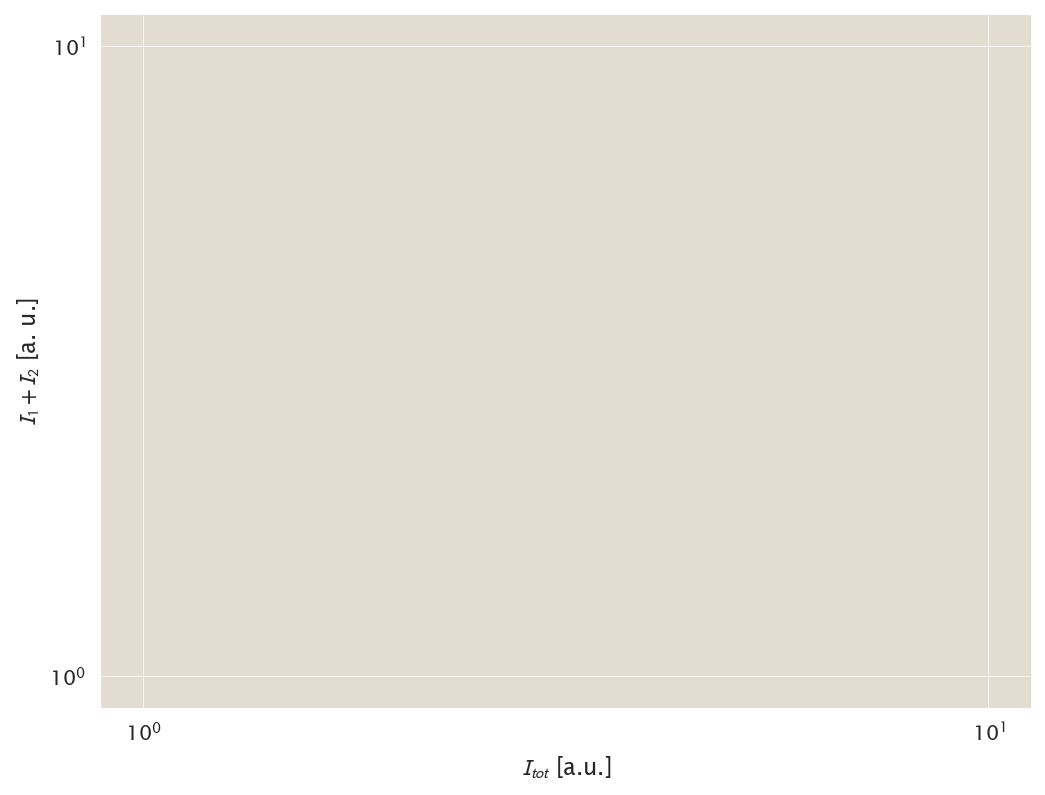

In [14]:
# Make the conservation of fluroescence plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$I_1 + I_2$ [a. u.]')

I_tot_range = np.logspace(2, 6, 500)
ax.plot(I_tot, (np.array(I_1) + np.array(I_2)), '.', color='slategray')
ax.plot(I_tot_range, I_tot_range, '-')

In [15]:
def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
    # Ensure that the intensity values are not negative.
#     if (I_1 <= 0).any() or (I_2 <= 0).any() or (I_tot <= 0).any():
#         return ValueError('I_1 and I_2 must be positive.')
    
    # Ensure that alpha is positive.
    if (alpha < 0) | (alpha > 2**16):
        return prefactor * -np.inf
    
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha 
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
     
    return prefactor * lp

In [16]:
#  Calculate the calibration factor.
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(I_1, I_2, I_1 + I_2))
alpha_opt = popt.x

In [19]:
popt.x

4015.2761287990857

In [17]:
class DeterministicLogPosterior(pm.Continuous):
    def __init__(self, I_1=None, I_2=None, *args, **kwargs):
        super(DeterministicLogPosterior, self).__init__(*args, **kwargs)
    def logp(self, value, *args):
        n1 = I_1 / value
        n2 = I_2 / value
        ntot = n1 + n2
        k = len(I_1)
        binom = tt.sum(tt.gammaln(ntot+1)) - tt.sum(tt.gammaln(n1+1)) -tt.sum(tt.gammaln(n2+1))
        return -k * tt.log(value) + binom - tt.sum(ntot) * tt.log(2)

In [18]:
with pm.Model() as model: 
    p = DeterministicLogPosterior('alpha', I_1, I_2, testval=500)
    trace = pm.sample(tune=500, draws=500, njobs=4, init='advi')
    trace_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_df) 

In file included from /Users/gchure/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.3-64/tmppugkeqdg/mod.cpp:1:
In file included from /Users/gchure/anaconda/include/python3.6m/Python.h:25:
/Users/gchure/anaconda/bin/../include/c++/v1/stdio.h:108:15: fatal error: 'stdio.h' file not found
#include_next <stdio.h>
              ^~~~~~~~~
1 error generated.



00001	#include <Python.h>
00002	#include <iostream>
00003	#include "theano_mod_helper.h"
00004	#include <math.h>
00005	#include <numpy/arrayobject.h>
00006	#include <numpy/arrayscalars.h>
00007	//////////////////////
00008	////  Support Code
00009	//////////////////////
00010	
00011	    namespace {
00012	    struct __struct_compiled_op_m66ca6565a50f51a1d42a23dd2f3879e3 {
00013	        PyObject* __ERROR;
00014	
00015	        PyObject* storage_V3;
00016	PyObject* storage_V1;
00017	        
00018	
00019	        __struct_compiled_op_m66ca6565a50f51a1d42a23dd2f3879e3() {
00020	            // This is only somewhat safe because we:
00021	            //  1) Are not a virtual class
00022	            //  2) Do not use any virtual classes in the members
00023	            //  3) Deal with mostly POD and pointers
00024	
00025	            // If this changes, we would have to revise this, but for
00026	            // now I am tired of chasing segfaults because
00027	            // initialization code

Exception: ("Compilation failed (return status=1): In file included from /Users/gchure/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.3-64/tmppugkeqdg/mod.cpp:1:. In file included from /Users/gchure/anaconda/include/python3.6m/Python.h:25:. /Users/gchure/anaconda/bin/../include/c++/v1/stdio.h:108:15: fatal error: 'stdio.h' file not found. #include_next <stdio.h>.               ^~~~~~~~~. 1 error generated.. ", '[InplaceDimShuffle{x}(alpha)]')

In [ ]:
_ = pm.traceplot(trace)

In [ ]:
alpha_opt = stats['mode'].values

In [ ]:
# Bin the data for plotting.
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='I_tot')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_I_tot = [data.iloc[bins[i-1]:bins[i]+1]['I_tot'].mean() for i in range(1, len(bins))] 
    return [np.array(mean_sq_diff), np.array(mean_I_tot)] 

In [ ]:
# Set up the data frame.
binning_df = pd.DataFrame(np.array([I_1, I_2, I_1 + I_2]).T, columns=['I_1', 'I_2', 'I_tot'])

# Bin the data. 
bin_size = 50
mean_sq_diff, mean_I_tot = binning_mean(binning_df, bin_width=bin_size, sort_values=True)

In [ ]:
# Make the scatter plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data
_ = ax.plot(np.array(I_1) + np.array(I_2), (np.array(I_1) - np.array(I_2))**2, '.', color='slategray', label='data')

# Plot the binned data.
_ = ax.plot(mean_I_tot, mean_sq_diff, 'o', color='dodgerblue', label='binned data')

# Plot the theory curve. 
I_tot_range = np.logspace(3, 6, 500)
theo = alpha_opt * I_tot_range
_ = ax.plot(I_tot_range, theo, '-', color='tomato', label='fit')

_ = ax.legend()

## Testing the calibration factor. 

In [ ]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data), 1) / len(data)

In [ ]:
# Plot the various fluorescence distributions.
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_xlabel('fluorescence intensity [a.u.]')
ax[0].set_ylabel('ECDF')
ax[1].set_xlabel('fluorescence intensity [a.u.]')
ax[1].set_ylabel('ECDF')


for a in ax:
    a.set_xscale('log')
     
# Group the data. 
grouped = snap_df.groupby(['strain', 'atc']) 
_yfp_colors = sns.color_palette('Greens_r', n_colors=7)
concs = np.sort(snap_df['atc'].unique())
yfp_colors = {i:j for i, j in zip(concs, _yfp_colors)}
_rfp_colors = sns.color_palette('Reds_r', n_colors=7)
rfp_colors = {i:j for i, j in zip(concs, _rfp_colors)}
for g, d in grouped:
    # Compute the two ECDFs
    YFP_x, YFP_y = ecdf(d['fluor2_birth_fluo'])
    RFP_x, RFP_y = ecdf(d['fluor1_birth_fluo'])
    
    # Figure out the colors
    if (g[0] == 'auto'):
        r_color = 'slategray'
        y_color = 'slategray'
        label = 'auto'
    elif 'delta' in g[0]:
        r_color = 'dodgerblue'
        y_color = 'dodgerblue'
        label = g[0]
    else:
        r_color = rfp_colors[g[1]]
        y_color = yfp_colors[g[1]]
        label = g[1]
        
    # Generate the plot
    if 'deltaLacI' == g[0]:
        _ = ax[0].step(YFP_x, YFP_y, color=y_color, label=label)
#     if 'deltaTetR' == g[0]:
#         _ = ax[1].step(RFP_x, RFP_y, color=y_color, label=label)
    else: 
        _ = ax[0].step(YFP_x, YFP_y, color=y_color, label=label)
        print(g[0], r_color)
        _ = ax[1].step(RFP_x, RFP_y, color=r_color, label=label)

_ = ax[0].legend()
_ = ax[1].legend()

plt.tight_layout()

In [ ]:
snap_df[snap_df['strain']=='deltaLacI']

That all makes sense

In [ ]:
# Subtract the autofluorescence from each channel.
snap_df.loc[:, 'fluor2_sub'] = snap_df['fluor2_birth_fluo'] - mean_auto_yfp * snap_df['birth_area']
snap_df.loc[:, 'fluor1_sub'] = snap_df['fluor1_birth_fluo'] - mean_auto_cherry * snap_df['birth_area']

# Compute the mean delta for each.
mean_delta_yfp = snap_df[snap_df['strain']=='deltaLacI']['fluor2_sub'].mean()
mean_delta_cherry = snap_df[snap_df['strain']=='deltaTetR']['fluor1_sub'].mean()

# Look at only the dilution strain and calculate the fold change.
dilution_strain = snap_df[snap_df['strain']=='dilution']
fold_change = []
repressors = []
grouped = dilution_strain.groupby('atc')
for g, d in grouped:
    mean_yfp = d['fluor2_sub'].mean()
    fold_change.append(mean_yfp / mean_delta_yfp)
    mean_repressors = np.mean(d['fluor1_sub'] / alpha_opt)
    repressors.append(mean_repressors)

In [ ]:
# Compute the prediction.
rep_range = np.logspace(-1, 3, 300)
fc_theo = (1 +  (1 / (1 + np.exp(-4.5))) * (rep_range / 5E6) * np.exp(13.9))**-1

# Generate the plot
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('number of repressors')
ax.set_ylabel('foldchange')
all_fc = dilution_strain['fluor2_sub'] / mean_delta_yfp
all_rep = dilution_strain['fluor1_sub'] / alpha_opt
# Plot the prediction.
_ = ax.plot(rep_range, fc_theo, color='slategray', label='theory')

# Plot the data
_ = ax.plot(np.array(repressors), fold_change, 'o', color='tomato', label='data')
# _ = ax.plot(all_rep, all_fc, ',', color='dodgerblue')


In [ ]:
np.array(np.array(repressors))